In [43]:
import tensorflow
# Mount drive
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


### Extract data

In [0]:

from zipfile import ZipFile

with ZipFile('/content/drive/My Drive/train.zip', 'r') as zf:
  zf.extractall()

### Get the list of names of images and masks and name the list imagelist and masklist.



In [0]:
imagelist = os.listdir('train/images')
masklist = os.listdir('train/masks')

In [49]:
#Test your list names by printing some of the names as given below.
print(imagelist[-1])
print(masklist[-1])
print(imagelist[10])
print(masklist[10])

7c6221dbb8.png
7c6221dbb8.png
1befe1ba44.png
1befe1ba44.png


### Read and test your images and respective masks.



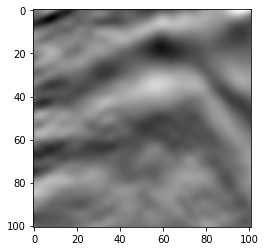

In [51]:
import  matplotlib.pyplot as plt
import cv2

plt.imshow(cv2.imread('train/images/{}'.format(imagelist[10])))

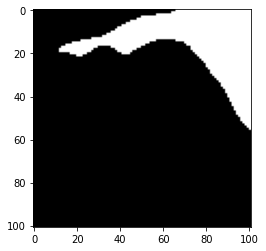

In [50]:
plt.imshow(cv2.imread('train/masks/{}'.format(masklist[10])))

In [66]:
im_height

128

In [52]:
import numpy as np

im_height, im_width = 128

# Get and resize train images and masks
def get_data(train=True):
    #ids = next(os.walk("train/images"))[2]
    X = np.zeros((len(imagelist), im_height, im_width, 1), dtype=np.float32)
    y = np.zeros((len(masklist), im_height, im_width, 1), dtype=np.float32)
    for n in imagelist:
        k = imagelist.index(n)
        image_path = os.path.join('train/images/' +n )
        mask_path = os.path.join('train/masks/' +n )
        
        # Load images
        img = cv2.imread(image_path, 0)
        resized_img = cv2.resize(img, (128, 128), interpolation = cv2.INTER_AREA)
        

        # Load masks
        if train:
            mask = cv2.imread(mask_path, 0)
            resized_mask = cv2.resize(mask, (128, 128), interpolation = cv2.INTER_AREA)
            resized_mask = np.reshape(resized_mask, (128,128,1))
            
           

        # Save images
        X[k, ..., 0] = resized_img.squeeze() / 255
        if train:
            y[k] = resized_mask/255
    print('Done!')
    if train:
        return X, y
    else:
        return X
    
X, y = get_data(train=True)

Done!


In [0]:
# Split train and valid
from sklearn.model_selection import train_test_split

X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.15, random_state=0)

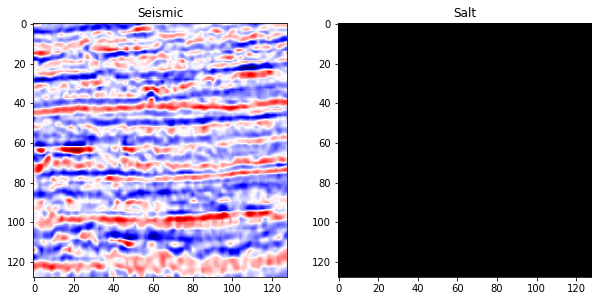

In [54]:
## Test your data whether it looks fine - Random check
import random 
# Check if training data looks all right
ix = random.randint(0, len(X_train))
has_mask = y_train[ix].max() > 0

fig, ax = plt.subplots(1, 2, figsize=(10, 10))

ax[0].imshow(X_train[ix, ..., 0], cmap='seismic', interpolation='bilinear')
if has_mask:
    ax[0].contour(y_train[ix].squeeze(), colors='k', levels=[0.5])
ax[0].set_title('Seismic')

ax[1].imshow(y_train[ix].squeeze(), interpolation='bilinear', cmap='gray')
ax[1].set_title('Salt');

### Define loss and dice_coeff function.

In [0]:
def dice_coefficient(y_true, y_pred):
    numerator = 2 * tensorflow.reduce_sum(y_true * y_pred)
    denominator = tensorflow.reduce_sum(y_true + y_pred)

    return numerator / (denominator + tensorflow.keras.backend.epsilon())

def loss(y_true, y_pred):
    return tensorflow.keras.backend.binary_crossentropy(y_true, y_pred) - tensorflow.math.log(dice_coefficient(y_true, y_pred) + tensorflow.keras.backend.epsilon())

### Build and compile UNet Model 



In [56]:
!pip install git+https://github.com/qubvel/segmentation_models

  Cloning https://github.com/qubvel/segmentation_models to /tmp/pip-req-build-8d7im98k
  Running command git clone -q https://github.com/qubvel/segmentation_models /tmp/pip-req-build-8d7im98k
  Running command git submodule update --init --recursive -q
  Created wheel for segmentation-models: filename=segmentation_models-1.0.1-cp36-none-any.whl size=33792 sha256=b785d1e6bc55500bb6d9d2e6c87a45a742d938c23c4af268c2f71383036bf348
  Stored in directory: /tmp/pip-ephem-wheel-cache-93x6z4px/wheels/49/cf/46/cbb4bb64518c402aea99df9d466f1081450597e653256bbcf4
Successfully built segmentation-models


In [0]:
from segmentation_models import Unet

model = Unet(backbone_name='resnet34', encoder_weights=None, input_shape=(None, None, 1))

In [0]:
model.compile(optimizer='Adam', loss=loss, metrics=[dice_coefficient])

In [59]:
model.summary()

Model: "model_4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
data (InputLayer)               (None, None, None, 1 0                                            
__________________________________________________________________________________________________
bn_data (BatchNormalization)    (None, None, None, 1 3           data[0][0]                       
__________________________________________________________________________________________________
zero_padding2d_35 (ZeroPadding2 (None, None, None, 1 0           bn_data[0][0]                    
__________________________________________________________________________________________________
conv0 (Conv2D)                  (None, None, None, 6 3136        zero_padding2d_35[0][0]          
____________________________________________________________________________________________

In [0]:
from segmentation_models import get_preprocessing

BACKBONE = 'resnet34'
preprocess_input = get_preprocessing(BACKBONE)
X_train = preprocess_input(X_train)
X_valid = preprocess_input(X_valid)

In [61]:
model.fit(
    x=X_train,
    y=y_train,
    batch_size=16,   
    epochs=1,
    validation_data=(X_valid, y_valid)
    )

Train on 3400 samples, validate on 600 samples
Epoch 1/1
3400/3400 [==============================] - 1320s 388ms/step - loss: 0.9937 - dice_coefficient: 0.5867 - val_loss: 2.8705 - val_dice_coefficient: 0.4439


In [62]:
preds_val = model.predict(X_valid, verbose=1)

600/600 [==============================] - 53s 88ms/step


In [0]:
#Get the threshold predictions to look at refined results.
preds_val_t = (preds_val > 0.5).astype(np.uint8)

In [0]:
#Plot a sample
def plot_sample(X, y, preds, binary_preds, ix=None):
    if ix is None:
        ix = random.randint(0, len(X))

    has_mask = y[ix].max() > 0

    fig, ax = plt.subplots(1, 4, figsize=(20, 10))
    ax[0].imshow(X[ix, ..., 0], cmap='seismic')
    if has_mask:
        ax[0].contour(y[ix].squeeze(), colors='k', levels=[0.5])
    ax[0].set_title('Seismic')

    ax[1].imshow(y[ix].squeeze())
    ax[1].set_title('Salt')

    ax[2].imshow(preds[ix].squeeze(), vmin=0, vmax=1)
    if has_mask:
        ax[2].contour(y[ix].squeeze(), colors='k', levels=[0.5])
    ax[2].set_title('Salt Predicted')
    
    ax[3].imshow(binary_preds[ix].squeeze(), vmin=0, vmax=1)
    if has_mask:
        ax[3].contour(y[ix].squeeze(), colors='k', levels=[0.5])
    ax[3].set_title('Salt Predicted binary');

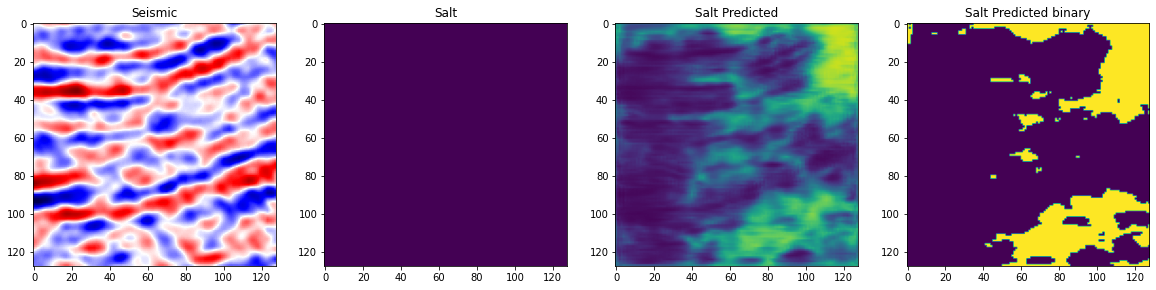

In [65]:
# Check if valid data looks all right
plot_sample(X_valid, y_valid, preds_val, preds_val_t, ix=15)